# Uncertainty analysis with arrays

Notebook on uncertainty analysis of site-dependent CFs usnig regionalized CFs.

# Setup

In [1]:
%matplotlib inline

In [2]:
import bw2regional as bwr
import bw2data as bd
import bw2calc as bc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from bw2regional.pandarus_remote import AlreadyExists
import bw_processing as bwp

In [3]:
bd.projects.set_current('LC IMPACT case study')

# Getting a CDF for global land use CFs

Use the consensus land-use cover map from [EarthEnv](https://www.earthenv.org/landcover) (class 7 - Cultivated and Managed Vegetation) as weights for the weighted average:

<img src="images/land_use_agriculture.png">

These values are normalized from 0 to 100, i.e. they are already densities (intensity per unit area), so we can use them directly.

You can get this file from [file.brightway.dev](https://files.brightway.dev/consensus_full_class_7.tif) if you aren't on the DdS server.

In [4]:
bwr.geocollections["agriculture"] = {
    'band': 1,
    'kind': 'raster',
    'filepath': '/srv/data/rasters/consensus_full_class_7.tif',
}

In [5]:
try:
    bwr.remote.calculate_rasterstats('ecoregions', 'agriculture')
except AlreadyExists:
    pass

In [6]:
bwr.remote.rasterstats_as_xt('ecoregions', 'agriculture', 'ecoregions-agriculture')

Brightway2 ExtensionTable: ecoregions-agriculture

In [7]:
bwr.ExtensionTable('ecoregions-agriculture').load()[:10]

[(23.075446724023827, ('ecoregions', 'AA0113')),
 (2.510703363914373, ('ecoregions', 'OC0103')),
 (25.750523497760224, ('ecoregions', 'PA0510')),
 (1.9328358208955223, ('ecoregions', 'AT0703')),
 (10.358433734939759, ('ecoregions', 'NT0216')),
 (26.454689577846732, ('ecoregions', 'PA1020')),
 (0.5691944832670912, ('ecoregions', 'NA0609')),
 (43.94561087735519, ('ecoregions', 'NT0801')),
 (5.084875558391832, ('ecoregions', 'OC0108')),
 (40.231609654059866, ('ecoregions', 'NT0704'))]

In [8]:
weights = {k: v for v, k in bwr.ExtensionTable('ecoregions-agriculture').load()}

To get the CDF for the CF distribution, we need the areal intensity per ecoregion, which we have from the raster, times the area of each ecoregion. We could calculate these areas ourselves, but we have them already from the areal intersections.

In [9]:
import collections

areas = collections.defaultdict(int)

for ecoregion, _, area in bwr.Intersection(('ecoregions', 'world-topo-ecoregions')).load():
    areas[ecoregion] += area

In [10]:
weighted_area = {k: v * weights.get(k, 0) for k, v in areas.items()}
total_weighted_area = sum(weighted_area.values())

Now we need the CFs themselves. All agricultural occupation gets the same CF, for better or worse, in LC-IMPACT. We will use the flow 'Occupation, permanent crop, non-irrigated, intensive' (the land use used for sugarcane in Brazil) for to retrieve the regionalized CFs.

In [11]:
land_use = bd.Database("biosphere3").get(name='Occupation, permanent crop, non-irrigated, intensive')

In [12]:
cf_mapping = {
    location: value 
    for key, value, location
    in bd.Method(('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Certain')).load()
    if key == land_use.key
}

In [13]:
EXCLUSIONS = {('ecoregions', 'Rock and Ice'), 'GLO'}

Calculate our global weighted average. The LC-IMPACT provided value is 6.18e-15.

In [14]:
sum(v * cf_mapping[k] for k, v in weighted_area.items() if k not in EXCLUSIONS) / total_weighted_area

2.5706916845254235e-13

We can also calculate the unweighted LC IMPACT average:

In [15]:
np.mean(list(cf_mapping.values()))

7.554634101941748e-13

Sampleing from a weighted distribution is a bit tricky; let's get the cumulative distribution function, fit a lognormal, and sample from that.

In [16]:
cfs_reverse = [(v, k) for k, v in cf_mapping.items() if k not in EXCLUSIONS]
cfs_reverse.sort()
xs = np.array([line[0] for line in cfs_reverse])
ys = np.cumsum(np.array([weighted_area.get(key, 0) for _, key in cfs_reverse])) / total_weighted_area
weights = np.array([weighted_area.get(key, 0) for _, key in cfs_reverse]) / total_weighted_area

In [17]:
def get_value_from_weighted_cfs():
    return xs[np.argmax(ys > np.random.random()) + 1]

## Check to make sure the sample function is reasonable

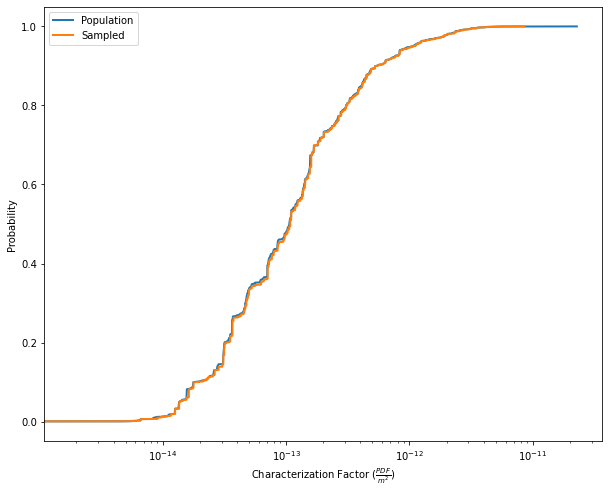

In [18]:
X = 10000
sample_xs = np.array([get_value_from_weighted_cfs() for _ in range(X)])
sample_xs.sort()
sample_ys = np.linspace(0, 1, X)

plt.figure(figsize=(10, 8))
plt.semilogx(xs, ys, lw=2, label="Population")
plt.semilogx(sample_xs, sample_ys, lw=2, label="Sampled")
plt.xlabel(r"Characterization Factor $( \frac{PDF}{m^{2}} )$")
plt.ylabel("Probability")
plt.legend()

# Graph population versus fitted lognormal

In [19]:
from scipy.stats import wasserstein_distance, norm, lognorm
from scipy.optimize import minimize

Initial guess for $\mu$ and $\sigma$ (log-transformed)

In [20]:
points = np.log(xs + 1e-16)

In [21]:
mu, sigma = np.average(points), np.std(points)
mu, sigma

(-29.827570376874117, 2.7857733263384237)

Function to calculate distance from observations

In [22]:
def distance_from_data(vector):
    mu, sigma = vector
    ln_sample = norm.ppf(np.linspace(0.01, 0.99, 1000), loc=mu, scale=sigma)
    return wasserstein_distance(points, ln_sample, u_weights=weights)  

Try to fit the normal distribution

In [23]:
result = minimize(distance_from_data, (mu, sigma), bounds=((None, None), (0, None)))
result

      fun: 0.09289685238625425
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00052935, -0.00010664])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 10
     njev: 28
   status: 0
  success: True
        x: array([-29.91611019,   1.3487268 ])

Plot fitted distribution, sampled values, and actual CFs

In [24]:
fit_mu, fit_sigma = result['x']

In [28]:
fit_mu, fit_sigma

(-29.916110194503702, 1.3487267955189421)

In [31]:
sample = np.exp(norm.rvs(loc=fit_mu, scale=fit_sigma, size=X))

In [32]:
sample_xs

array([0.00e+00, 0.00e+00, 0.00e+00, ..., 8.07e-12, 8.57e-12, 8.57e-12])

In [ ]:
norm.cdf(sample_xs, loc=fit_mu, scale=fit_sigma)

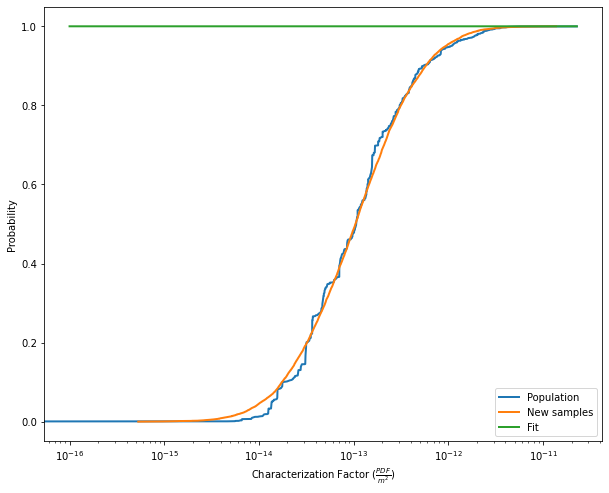

In [26]:
fitted_xs = np.linspace(min(points), max(points), X)
fitted_ys = norm.cdf(sample_xs, loc=fit_mu, scale=fit_sigma)

plt.figure(figsize=(10, 8))
plt.semilogx(xs, ys, lw=2, label="Population")
plt.semilogx(np.sort(sample), np.linspace(0, 1, X), lw=2, label="New samples")
plt.semilogx(np.exp(fitted_xs), fitted_ys, lw=2, label="Fit")
plt.xlabel(r"Characterization Factor $( \frac{PDF}{m^{2}} )$")
plt.ylabel("Probability")
plt.legend()

# Write arrays

In [33]:
LAND_USE_NAMES = {        
    "Occupation, annual crop",
    "Occupation, annual crop, greenhouse",
    "Occupation, annual crop, irrigated",
    "Occupation, annual crop, irrigated, intensive",
    "Occupation, annual crop, non-irrigated",
    "Occupation, annual crop, non-irrigated, extensive",
    "Occupation, annual crop, non-irrigated, intensive",
    "Occupation, arable land, unspecified use",
}

LAND_USE = [bd.Database("biosphere3").get(name=name) for name in LAND_USE_NAMES]
len(LAND_USE)

8

In [34]:
array = np.hstack([sample_xs.reshape((-1, 1))] * len(LAND_USE)).T

In [35]:
indices = np.array([(obj.id, 1) for obj in LAND_USE], dtype=bwp.INDICES_DTYPE)

In [36]:
dp = bwp.create_datapackage()

In [37]:
dp.add_persistent_array(
    matrix="characterization_matrix",
    data_array=array,
    indices_array=indices,
    global_index=bd.geomapping[bd.config.global_location],
)

# Compare site-generic LCIA with and without presamples

In [38]:
fu, data_objs, _ = bd.prepare_lca_inputs(
    demand={('Fuel comparison', 'sugarcane transport'): 1},
    method=('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Certain')
)

In [39]:
data_objs.append(dp)

In [40]:
def get_n_iterations(lca, n):
    results = []
    
    for _ in range(n):
        next(lca)
        results.append(lca.score)
        
    return np.array(results)

In [51]:
lca = bc.LCA(fu, data_objs=data_objs, use_arrays=False, use_distributions=True)
lca.lci()
lca.lcia()

In [52]:
mc_with_distributions = get_n_iterations(lca, 100)

In [44]:
lca2 = bc.LCA(fu, data_objs=data_objs, use_arrays=True)
lca2.lci()
lca2.lcia()

In [45]:
mc_with_arrays = get_n_iterations(lca2, 100)

In [47]:
lca3 = bc.LCA(fu, data_objs=data_objs, use_arrays=True, use_distributions=True)
lca3.lci()
lca3.lcia()

In [48]:
mc_with_arrays_with_distributions = get_n_iterations(lca3, 100)

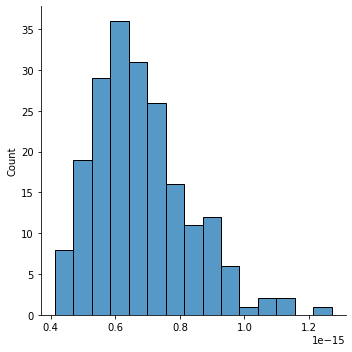

In [53]:
sb.displot(mc_with_distributions)

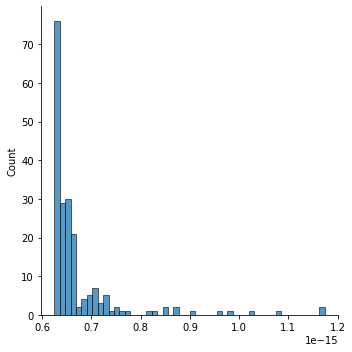

In [46]:
sb.displot(mc_with_arrays)

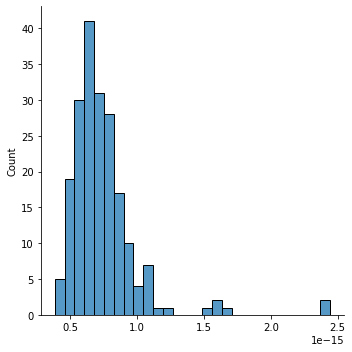

In [49]:
sb.displot(mc_with_arrays_with_distributions)